# AMS 520 Final Project

This notebook contains codes and report implementing 'Model high-frequency limit order book dynamics with SVM' written by Edward Cummings, Anton Malandii, Jack Peters, and Weiwei Tao.

In [47]:
!pip install -qq pyarrow
!pip install -qq xgboost

In [48]:
import functools as fn
import datetime
import math

import pandas as pd
import numpy as np
import scipy.stats as scs
from sklearnex import patch_sklearn ## Must run patch before importing other sklearn functions!!!
patch_sklearn()
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.svm import NuSVC
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import DecisionBoundaryDisplay

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os
os.add_dll_directory('C:\Aorda\PSG\lib')
import psgpython
import xgboost as xgb

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Part 1. Data Exploration

### Trade dataset

The trade dataset contains 243K UTP trade records from 14 different Stock Exchanges on 2022-01-06 between 4 a.m. until 8 p.m. EST for AAPL.


### Quote dataset
The quote dataset contains 473K UTP quote records from 13 different Stock Exchanges on 2022-01-06 for AAPL.

In [49]:
t = pd.read_csv('query_trades_AAPL_20200106_born202210121745.csv',)
q = pd.read_csv('query_quotes_AAPL_20200106_born202210121744.csv',)

C:\Users\tonma\AppData\Local\Temp\ipykernel_11384\2188346647.py:2: DtypeWarning:

Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.



In [50]:
t.shape, q.shape

((242878, 17), (473340, 31))

## Part 2. Data Cleaning

We first removed the closing/opening auction dissemination ( remove first and last 15 min) and excluded trades from the exchange D from our analysis. Then, trades and quote updates that stem from the same marketable order execution were regrouped together. We used the participant timestamp to assign a unique marketable order execution (MOX) identifier to each batch of trades and quotes triggered in execution of a single marketable order. Note that the reason that the participant timestamp can be used to derive the MOX identifier because all trades and quote updates that are triggered in the execution of the same marketable order receive the same participant (but not SIP) timestamp in high resolution.

After data cleaning, the analysis dataset contains 395K records. For each records, following features are generated:
1. Time
2. ask/bid price/volume, mid price, spread
3. dPask_dt, dPbid_dt, dVask_dt, dVbid_dt
4. average trade price/volume within 10ms, 100ms, 1s and 10s. 

In [51]:
from taq_data_cleaning import gen_basic_features_TAQ, gen_targets_events, gen_targets_temporal

In [52]:
df_features = gen_basic_features_TAQ(t, q,)

print(df_features.shape)
print(df_features.columns)
df_features.head()

(395698, 20)
Index(['index', 'time', 'ask_price', 'bid_price', 'ask_volume', 'bid_volume',
       'mid_price', 'spread', 'dPask_dt', 'dPbid_dt', 'dVask_dt', 'dVbid_dt',
       'avg_trade_price_10ms', 'avg_trade_price_100ms', 'avg_trade_price_1s',
       'avg_trade_price_10s', 'avg_trade_volume_10ms',
       'avg_trade_volume_100ms', 'avg_trade_volume_1s',
       'avg_trade_volume_10s'],
      dtype='object')


,index,time,ask_price,bid_price,ask_volume,bid_volume,mid_price,spread,dPask_dt,dPbid_dt,dVask_dt,dVbid_dt,avg_trade_price_10ms,avg_trade_price_100ms,avg_trade_price_1s,avg_trade_price_10s,avg_trade_volume_10ms,avg_trade_volume_100ms,avg_trade_volume_1s,avg_trade_volume_10s
id,,,,,,,,,,,,,,,,,,,,
2214126,42179,35100.044580,295.08,295.04,1.0,1.0,295.060,0.04,-0.01,-0.01,-2.0,-1.0,81.468781,81.468781,73.762734,92.485452,38.522388,38.522388,33.826923,23.284404
2214141,42181,35100.044763,295.07,295.04,1.0,1.0,295.055,0.03,0.00,0.00,-4.0,0.0,82.530920,82.530920,76.081708,92.538789,37.041958,37.041958,33.943396,22.974242
2214146,42182,35100.044834,295.06,295.04,2.0,1.0,295.050,0.02,0.00,0.01,-1.0,0.0,85.722849,85.722849,82.688227,93.314248,37.817568,37.817568,36.286624,23.287651
2214167,42183,35100.045857,295.06,295.04,3.0,1.0,295.050,0.02,-0.02,0.00,2.0,0.0,87.061311,87.061311,95.780210,95.865806,38.918033,38.918033,29.251309,22.156566
2214865,42184,35100.094862,295.06,295.04,2.0,1.0,295.050,0.02,-0.03,-0.03,0.0,0.0,84.716192,84.716192,95.503117,94.753454,44.059406,44.059406,34.942029,24.146264


## Part 3. Generate Labels

Both event-base and time-based outcomes were evaluated. 
1. After 30 orders, whether the price and spread will go down, unchanged or up.
2. After 100 ms, whether the price and spread will go down, unchanged or up.

In [53]:
df_events = gen_targets_events(q,num_events=30)
df_events.set_index('id', inplace = True)
df_events.head()

C:\Users\tonma\AMS 520\Project\taq_data_cleaning.py:329: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.

C:\Users\tonma\AMS 520\Project\taq_data_cleaning.py:331: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.



,index,time,midup,middown,mideq,spreadup,spreaddown,spreadeq
id,,,,,,,,
2214126,42179,35100.044580,False,True,False,False,False,True
2214141,42181,35100.044763,False,True,False,False,False,True
2214146,42182,35100.044834,False,True,False,False,False,True
2214167,42183,35100.045857,False,True,False,False,False,True
2214865,42184,35100.094862,False,True,False,False,False,True


In [54]:
df_targets_time = gen_targets_temporal(q,prediction_interval=100)
df_targets_time.sample(8)

C:\Users\tonma\AMS 520\Project\taq_data_cleaning.py:372: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,index,id,time,midup100ms,middown100ms,mideq100ms,spreadup100ms,spreaddown100ms,spreadeq100ms
268995,268995,18266133,47447.264185,False,False,True,False,False,False
348022,348022,24257903,54072.426803,False,False,True,False,False,False
80862,80862,6573562,37486.613796,False,False,True,False,False,False
149232,149232,10762152,40336.722689,False,False,True,False,False,False
33579,33579,3729630,35865.518584,False,False,True,False,False,False
115673,115673,8582872,38771.920424,False,False,True,False,False,False
125683,125683,9171879,39171.699834,False,False,True,False,False,False
37961,37961,3952628,35987.300069,False,False,True,False,False,False


In [55]:
df_combine = pd.merge(df_events, df_features, left_index=True, right_index=True)
df_events.shape, df_features.shape, df_combine.shape

((395668, 8), (395698, 20), (395668, 28))

In [56]:
df_combine.columns

Index(['index_x', 'time_x', 'midup', 'middown', 'mideq', 'spreadup',
       'spreaddown', 'spreadeq', 'index_y', 'time_y', 'ask_price', 'bid_price',
       'ask_volume', 'bid_volume', 'mid_price', 'spread', 'dPask_dt',
       'dPbid_dt', 'dVask_dt', 'dVbid_dt', 'avg_trade_price_10ms',
       'avg_trade_price_100ms', 'avg_trade_price_1s', 'avg_trade_price_10s',
       'avg_trade_volume_10ms', 'avg_trade_volume_100ms',
       'avg_trade_volume_1s', 'avg_trade_volume_10s'],
      dtype='object')

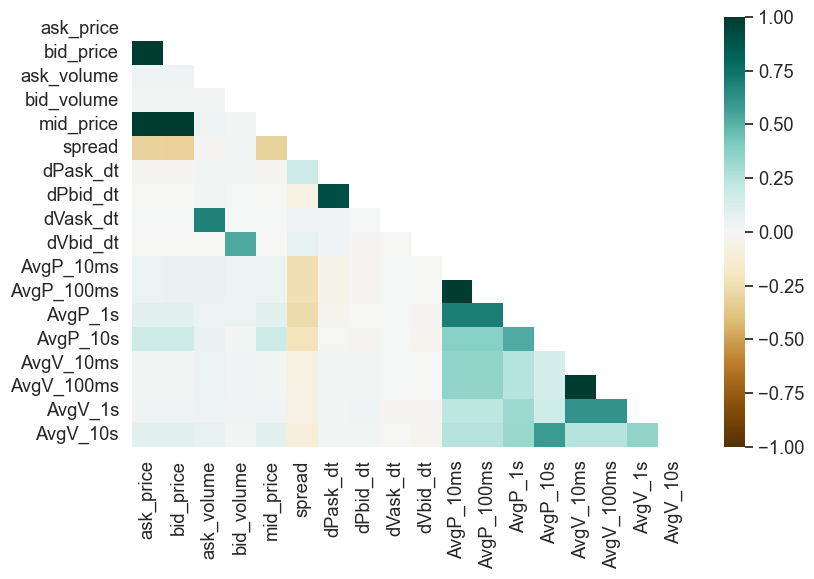

In [57]:
df_combine.rename(columns = {'avg_trade_price_10ms':'AvgP_10ms', 
                             'avg_trade_price_100ms':'AvgP_100ms', 
                             'avg_trade_price_1s':'AvgP_1s', 
                             'avg_trade_price_10s':'AvgP_10s', 
                             'avg_trade_volume_10ms':'AvgV_10ms', 
                             'avg_trade_volume_100ms':'AvgV_100ms', 
                             'avg_trade_volume_1s':'AvgV_1s', 
                             'avg_trade_volume_10s':'AvgV_10s', 
                            }, inplace = True)

focus_columns = ['ask_price', 'bid_price', 'ask_volume', 'bid_volume', 
                 'mid_price', 'spread', 'dPask_dt', 'dPbid_dt', 'dVask_dt', 'dVbid_dt', 
                 'AvgP_10ms', 'AvgP_100ms', 'AvgP_1s', 'AvgP_10s', 
                 'AvgV_10ms', 'AvgV_100ms', 'AvgV_1s', 'AvgV_10s']

corr=df_combine[focus_columns].corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

heat_fig, (ax)=plt.subplots(1, 1, figsize=(8,5))

heat=sns.heatmap(corr, 
                   ax=ax,  
                   mask=mask, vmin=-1, vmax=1, annot=False, cmap='BrBG')

heat_fig.subplots_adjust(top=.93)

In [58]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(corr, n=5):
    au_corr = corr.abs().unstack()
    labels_to_drop = get_redundant_pairs(corr)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(corr, 10))

Top Absolute Correlations
AvgV_10ms   AvgV_100ms    1.000000
AvgP_10ms   AvgP_100ms    1.000000
bid_price   mid_price     0.999991
ask_price   mid_price     0.999991
            bid_price     0.999965
dPask_dt    dPbid_dt      0.908305
AvgP_100ms  AvgP_1s       0.699192
AvgP_10ms   AvgP_1s       0.699192
ask_volume  dVask_dt      0.680882
AvgV_10ms   AvgV_1s       0.615562
dtype: float64


array([[<AxesSubplot: xlabel='Time of the Day'>,
        <AxesSubplot: xlabel='Time of the Day'>,
        <AxesSubplot: xlabel='Time of the Day'>],
       [<AxesSubplot: xlabel='Time of the Day'>,
        <AxesSubplot: xlabel='Time of the Day'>,
        <AxesSubplot: xlabel='Time of the Day'>]], dtype=object)

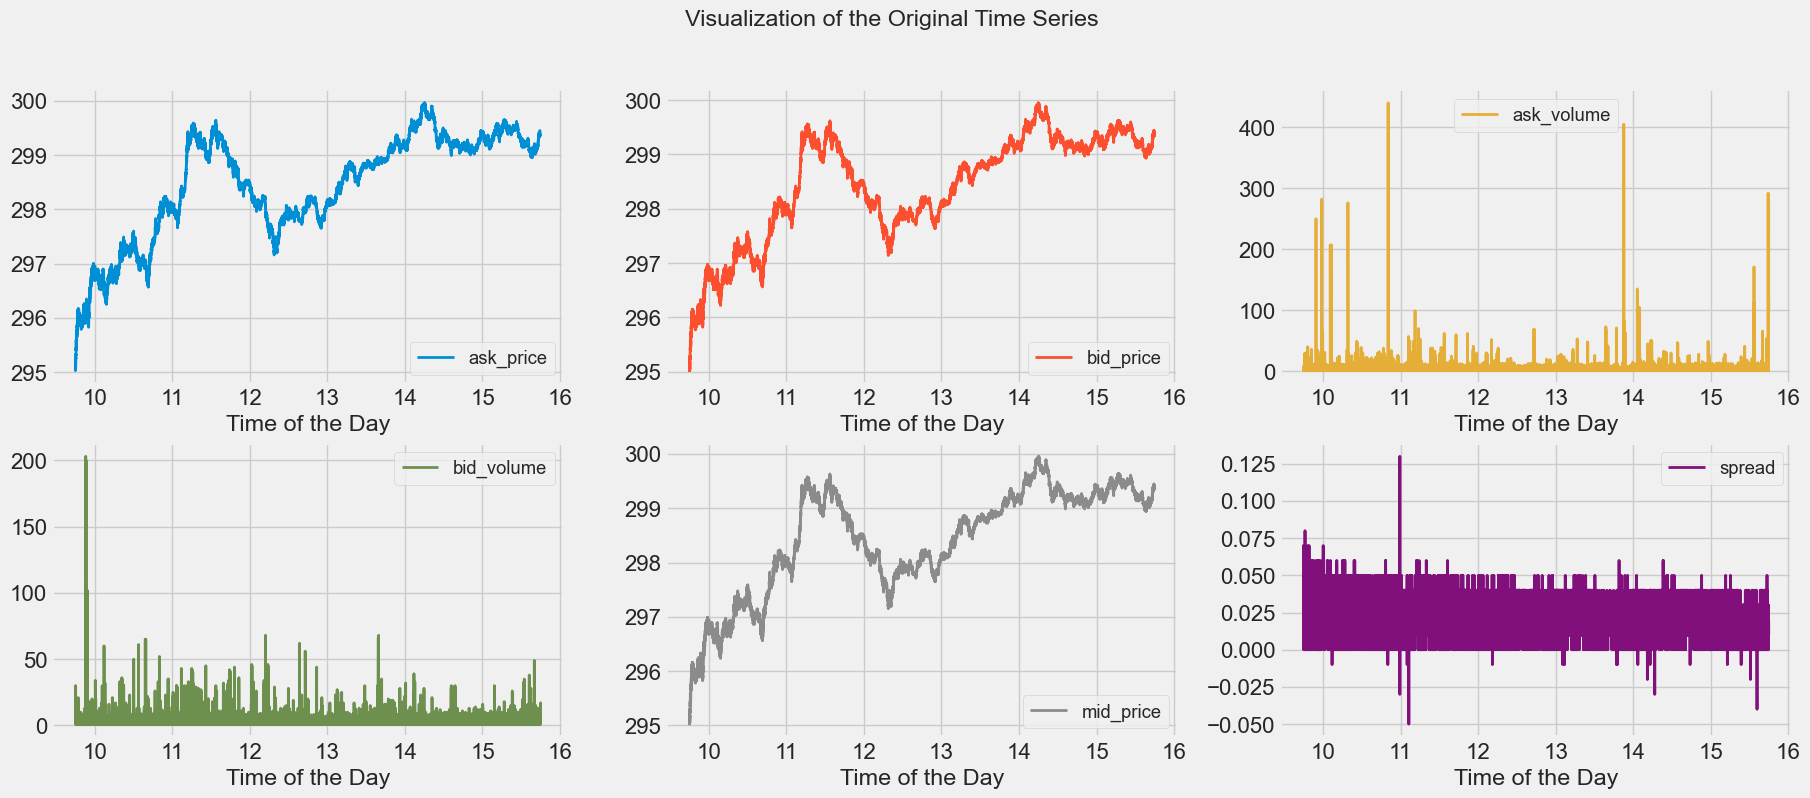

In [59]:
df_features['hour'] = df_features['time']/3600
df_features.set_index('hour', inplace = True)
cols = ['ask_price', 'bid_price', 'ask_volume', 'bid_volume', 'mid_price', 'spread']

import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000


plt.style.use('fivethirtyeight')
df_features[cols].plot(subplots=True, figsize=(20, 8),fontsize=16, sharex=False, layout=(2, 3),  linewidth=2, 
                       xlabel = 'Time of the Day', title='Visualization of the Original Time Series')

## Part 4. Train-Test Splitting

In [60]:
df_combine.loc[df_combine['midup'] == True, 'ymid'] = 'Up'
df_combine.loc[df_combine['mideq'] == True, 'ymid'] = 'Equal'
df_combine.loc[df_combine['middown'] == True, 'ymid'] = 'Down'
df_combine['ymid'].value_counts()

Up       180750
Down     168575
Equal     46343
Name: ymid, dtype: int64

In [61]:
df_combine.loc[df_combine['spreadup'] == True, 'yspread'] = 'Up'
df_combine.loc[df_combine['spreadeq'] == True, 'yspread'] = 'Equal'
df_combine.loc[df_combine['spreaddown'] == True, 'yspread'] = 'Down'
df_combine['yspread'].value_counts()

Equal    337248
Down      32051
Up        26369
Name: yspread, dtype: int64

In [84]:
encoder = LabelEncoder()
df_combine['y'] = encoder.fit_transform(df_combine['ymid'])

# X_train, X_test, y_train, y_test=train_test_split(df_combine[focus_columns], df_combine['y'], test_size=0.1 ,shuffle=False, stratify=None)
# X_train.shape, X_test.shape, y_train.shape, y_test.shape

## Part 5. Build Classification Models

In [85]:
# Frequency distribution of classes
train_outcome = pd.crosstab(index = df_combine['y'],  # Make a crosstab
                              columns="count")      # Name the count column

train_outcome

col_0,count
y,
0,168575
1,46343
2,180750


In [86]:
# Visualizing Outcome Distribution 
temp = df_combine['y'].value_counts()
df_plt = pd.DataFrame({'labels': ['Up', 'Down', 'Equal'] , 'values': temp.values})

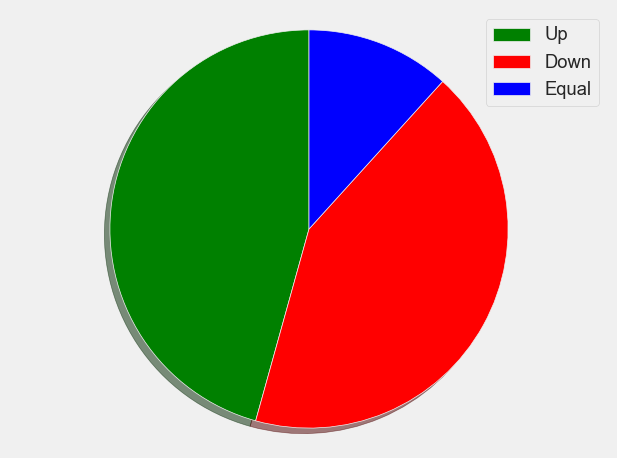

In [87]:
labels = df_plt['labels']
sizes = df_plt['values']
colors = ['green', 'red', 'blue']

patches, texts = plt.pie(sizes, colors=colors, shadow=True, startangle=90, pctdistance=1.1, labeldistance=1.2)
plt.legend(patches, labels, loc="best")
plt.axis('equal')
plt.tight_layout()
plt.show()

In [88]:
df_combine['y'] = df_combine['y'].apply(lambda x: 1 if x==2 else 0) # midup = 1, (middown,mideq) = (0,0)

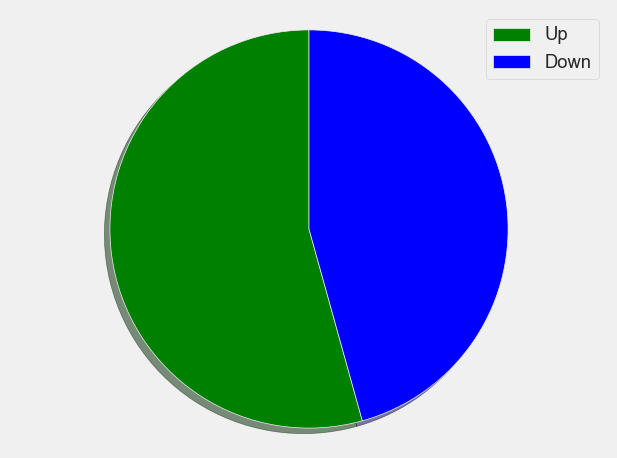

In [91]:
# Visualizing the New Outcome Distribution 
temp_new = df_combine['y'].value_counts()
df_plt = pd.DataFrame({'labels': ['Up','Down'], 'values': temp_new.values})

labels = df_plt['labels']
sizes = df_plt['values']
colors = ['green', 'blue']

patches, texts = plt.pie(sizes, colors=colors, shadow=True, startangle=90, pctdistance=1.1, labeldistance=1.2)
plt.legend(patches, labels, loc="best")
plt.axis('equal')
plt.tight_layout()
plt.show()

In [93]:
X = df_combine[focus_columns]
Y = df_combine['y']

In [94]:
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.2, random_state = 0, stratify=Y)

In [95]:
df_transformed = pd.DataFrame()

In [96]:
for name in X.columns:
    x_1 = X_train[name].to_numpy()  # index = 1 corresponds to train data, index = 2 corresponds to all data
    x_2 = X[name].to_numpy()
    x_1 = np.reshape(x_1,(len(X_train),1))
    x_2 = np.reshape(x_2,(len(X),1))
    bench_1 = y_train.to_numpy()
    bench_2 = Y.to_numpy()
    mat_sc_1 = np.column_stack((x_1, bench_1))
    mat_sc_2 = np.column_stack((x_2, bench_2))
    header = ["x%d" % (i) for i in range(1,mat_sc_1.shape[1])]
    matrix_DTI_spl_1 = [header + ['scenario_benchmark'], mat_sc_1]
    matrix_DTI_spl_2 = [header + ['scenario_benchmark'], mat_sc_2]
    parameters_body = np.reshape(np.array([3,5,3],dtype='float64'),(3,1))
    matrix_parameters_5_pieces = [header, parameters_body]
    
# Optimizing spline coeffs using training data
    allowExternal = True
    suppressMessages = False
    problem_name = "spline_test"
    problem_statement = "maximize\n\
    logexp_sum(spline_sum(matrix_parameters_5_pieces, matrix_DTI_spl_1))"

    problem_dictionary = {'problem_name':problem_name, 'problem_statement':problem_statement, 'matrix_DTI_spl_1':matrix_DTI_spl_1,
    'matrix_parameters_5_pieces':matrix_parameters_5_pieces}

    res = psgpython.psg_solver(problem_dictionary, allowExternal, suppressMessages)
    
# Transforming all the data
    allowExternal = True
    suppressMessages = False
    problem_name = "spline_test_1"
    problem_statement = "calculate\n\
    Point: point_problem_2\n\
    logistic(spline_sum(matrix_parameters_5_pieces, matrix_DTI_spl_2))"

    problem_dictionary = {'problem_name':problem_name, 'problem_statement':problem_statement, 'matrix_DTI_spl_2':matrix_DTI_spl_2,
    'matrix_parameters_5_pieces':matrix_parameters_5_pieces, 'point_problem_2': res['point_problem_1']}

    res_2 = psgpython.psg_solver(problem_dictionary, allowExternal, suppressMessages)

    df_transformed[name] = res_2['vector_logistic']


Running solver
Reading problem formulation
Asking for data information
Getting data
100% of matrix_parameters_5_pieces was read
100% of matrix_dti_spl_1 was read
Start optimization
Ext.iteration=0  Objective=-.693147180560E+00  Residual=0.000000000000E+00
Ext.iteration=18  Objective=-.689174309910E+00  Residual=0.000000000000E+00
Ext.iteration=38  Objective=-.689137987658E+00  Residual=0.000000000000E+00
Ext.iteration=54  Objective=-.689137817446E+00  Residual=0.000000000000E+00
Ext.iteration=74  Objective=-.689136795967E+00  Residual=0.000000000000E+00
Ext.iteration=93  Objective=-.689131733299E+00  Residual=0.000000000000E+00
Ext.iteration=110  Objective=-.689117246415E+00  Residual=0.000000000000E+00
Ext.iteration=129  Objective=-.689101413881E+00  Residual=0.000000000000E+00
Ext.iteration=140  Objective=-.689101162000E+00  Residual=0.000000000000E+00
Optimization is stopped
Solution is optimal
Calculating resulting outputs. Writing solution.
Objective: objective = -0.689101162000 [

Start calculation
Ext.iteration=0  Objective=0.000000000000E+00  Residual=0.000000000000E+00
Calculation was stopped
Point is calculated
Calculating resulting outputs. Writing solution.
Objective: objective = 0.00000000000
Solver has normally finished. Solution was saved.
Problem: problem_1, solution_status = calculated
Timing: data_loading_time = 0.07, preprocessing_time = 0.53, solving_time = 0.07
Variables: optimal_point = point_problem_1
Objective: objective = 0.00000000000
Function: logistic(spline_sum(matrix_parameters_5_pieces,matrix_dti_spl_2)) = vector_logistic
OK. Solver Finished

Running solver
Reading problem formulation
Asking for data information
Getting data
100% of matrix_parameters_5_pieces was read
100% of matrix_dti_spl_1 was read
Start optimization
Ext.iteration=0  Objective=-.693147180560E+00  Residual=0.000000000000E+00
Ext.iteration=18  Objective=-.689153096521E+00  Residual=0.000000000000E+00
Ext.iteration=32  Objective=-.689134637787E+00  Residual=0.00000000000

Start calculation
Ext.iteration=0  Objective=0.000000000000E+00  Residual=0.000000000000E+00
Calculation was stopped
Point is calculated
Calculating resulting outputs. Writing solution.
Objective: objective = 0.00000000000
Solver has normally finished. Solution was saved.
Problem: problem_1, solution_status = calculated
Timing: data_loading_time = 0.07, preprocessing_time = 0.53, solving_time = 0.06
Variables: optimal_point = point_problem_1
Objective: objective = 0.00000000000
Function: logistic(spline_sum(matrix_parameters_5_pieces,matrix_dti_spl_2)) = vector_logistic
OK. Solver Finished

Running solver
Reading problem formulation
Asking for data information
Getting data
100% of matrix_parameters_5_pieces was read
100% of matrix_dti_spl_1 was read
Start optimization
Ext.iteration=0  Objective=-.693147180560E+00  Residual=0.000000000000E+00
Ext.iteration=22  Objective=-.689397057557E+00  Residual=0.000000000000E+00
Ext.iteration=42  Objective=-.689311113695E+00  Residual=0.00000000000

Start optimization
Ext.iteration=0  Objective=-.693147180560E+00  Residual=0.000000000000E+00
Ext.iteration=22  Objective=-.689399373633E+00  Residual=0.000000000000E+00
Ext.iteration=44  Objective=-.689210418037E+00  Residual=0.000000000000E+00
Ext.iteration=64  Objective=-.689183680111E+00  Residual=0.000000000000E+00
Ext.iteration=86  Objective=-.689175599968E+00  Residual=0.000000000000E+00
Ext.iteration=108  Objective=-.689174757027E+00  Residual=0.000000000000E+00
Ext.iteration=130  Objective=-.689174159497E+00  Residual=0.000000000000E+00
Ext.iteration=141  Objective=-.689174081612E+00  Residual=0.000000000000E+00
Optimization is stopped
Solution is optimal
Calculating resulting outputs. Writing solution.
Objective: objective = -0.689174081612 [5.730617147481E-08]
Solver has normally finished. Solution was saved.
Problem: problem_1, solution_status = optimal
Timing: data_loading_time = 0.06, preprocessing_time = 0.51, solving_time = 13.61
Variables: optimal_point = point_problem

Solver has normally finished. Solution was saved.
Problem: problem_1, solution_status = calculated
Timing: data_loading_time = 0.12, preprocessing_time = 0.77, solving_time = 0.07
Variables: optimal_point = point_problem_1
Objective: objective = 0.00000000000
Function: logistic(spline_sum(matrix_parameters_5_pieces,matrix_dti_spl_2)) = vector_logistic
OK. Solver Finished

Running solver
Reading problem formulation
Asking for data information
Getting data
100% of matrix_parameters_5_pieces was read
100% of matrix_dti_spl_1 was read
Start optimization
Ext.iteration=0  Objective=-.693147180560E+00  Residual=0.000000000000E+00
Ext.iteration=20  Objective=-.688506791623E+00  Residual=0.000000000000E+00
Ext.iteration=43  Objective=-.688257566475E+00  Residual=0.000000000000E+00
Ext.iteration=66  Objective=-.688242952202E+00  Residual=0.000000000000E+00
Ext.iteration=86  Objective=-.688242306310E+00  Residual=0.000000000000E+00
Ext.iteration=95  Objective=-.688242282845E+00  Residual=0.000000

Start calculation
Ext.iteration=0  Objective=0.000000000000E+00  Residual=0.000000000000E+00
Calculation was stopped
Point is calculated
Calculating resulting outputs. Writing solution.
Objective: objective = 0.00000000000
Solver has normally finished. Solution was saved.
Problem: problem_1, solution_status = calculated
Timing: data_loading_time = 0.06, preprocessing_time = 0.51, solving_time = 0.06
Variables: optimal_point = point_problem_1
Objective: objective = 0.00000000000
Function: logistic(spline_sum(matrix_parameters_5_pieces,matrix_dti_spl_2)) = vector_logistic
OK. Solver Finished



In [105]:
column_names = ['ask_price', 'bid_price', 'ask_volume', 'bid_volume', 'mid_price',
                'spread', 'dPask_dt', 'dPbid_dt', 'dVask_dt', 'dVbid_dt', 'AvgP_10ms',
                'AvgP_100ms', 'AvgP_1s', 'AvgP_10s', 'AvgV_10ms', 'AvgV_100ms',
                'AvgV_1s', 'AvgV_10s']

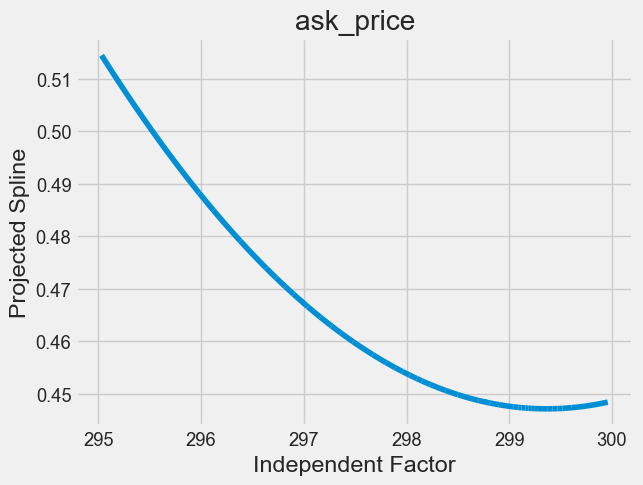

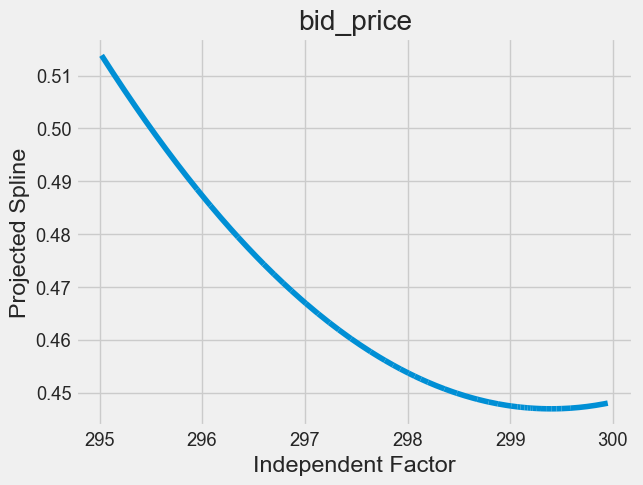

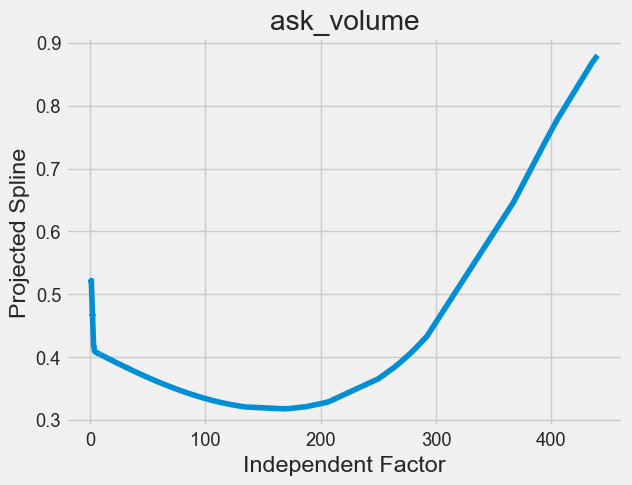

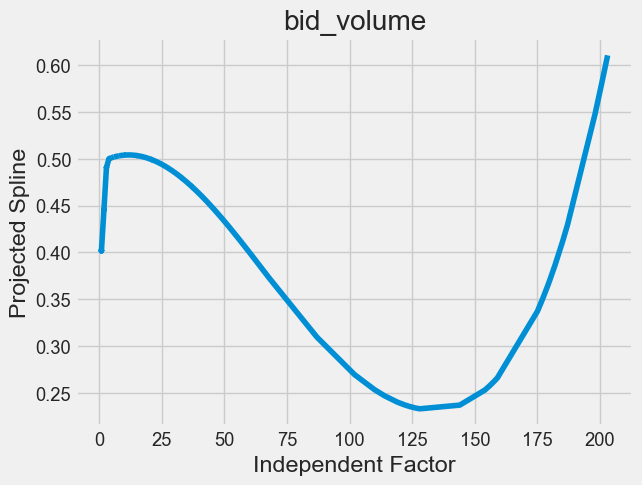

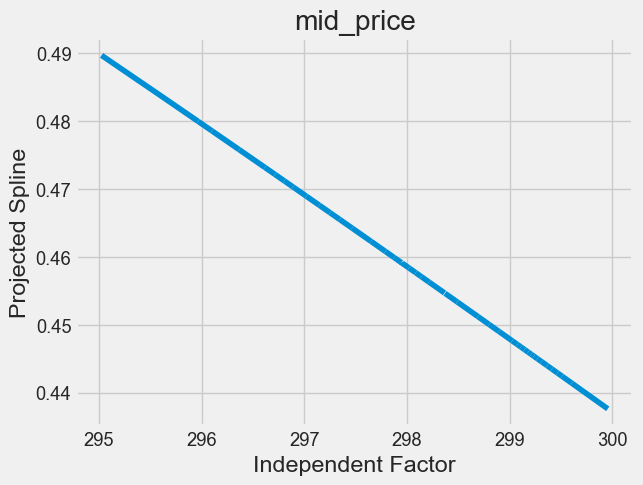

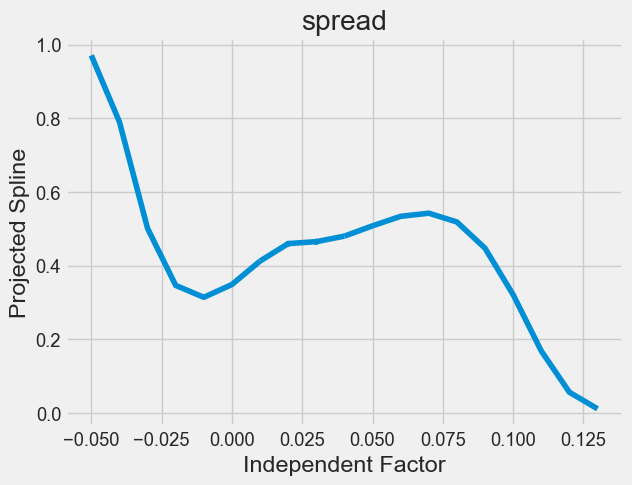

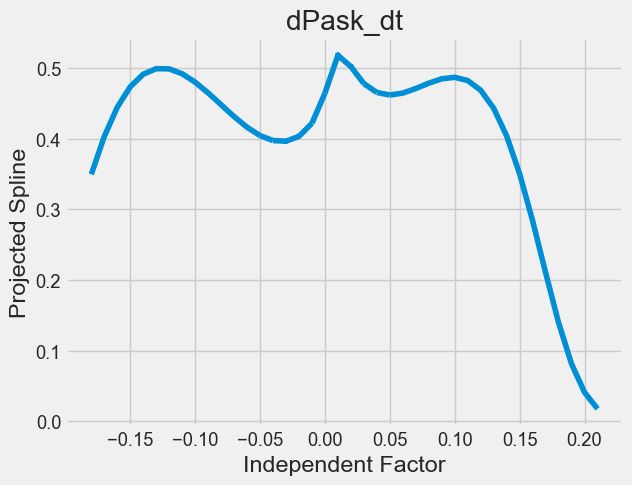

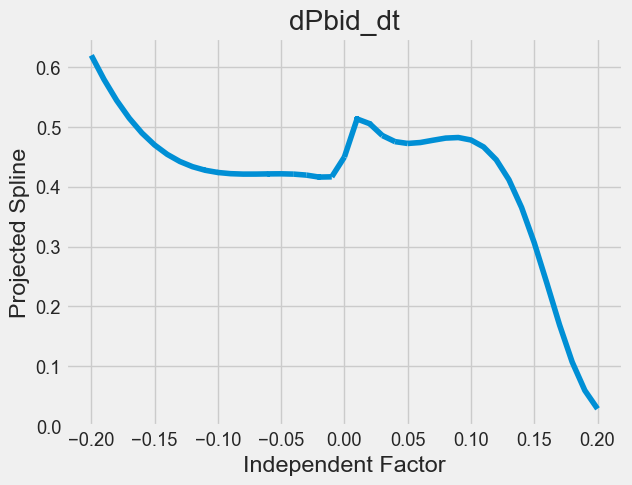

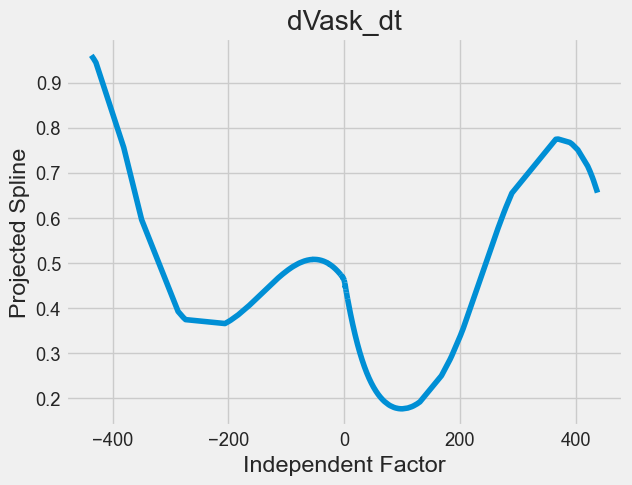

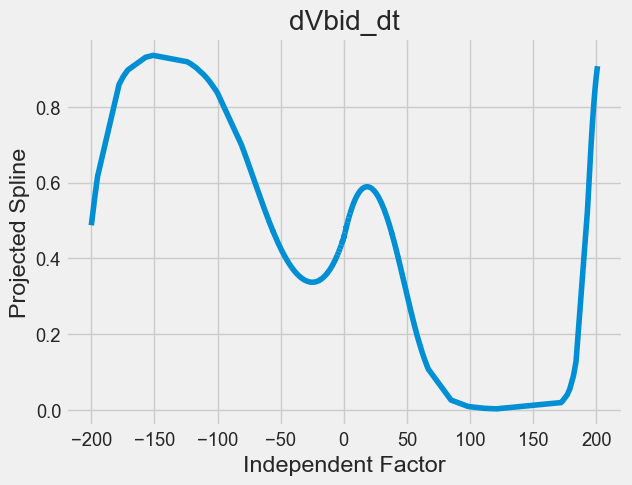

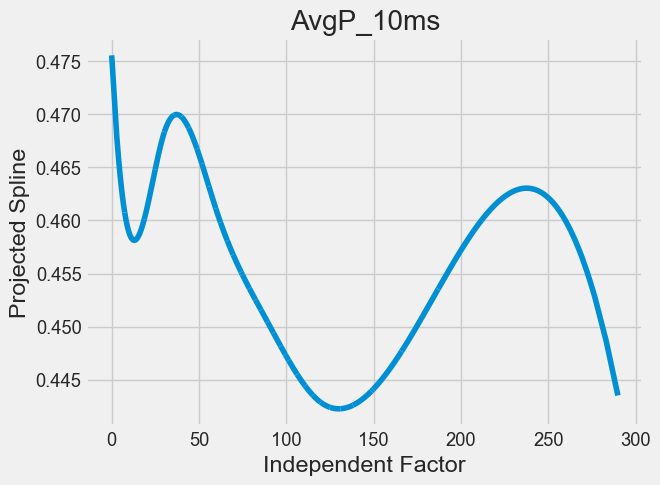

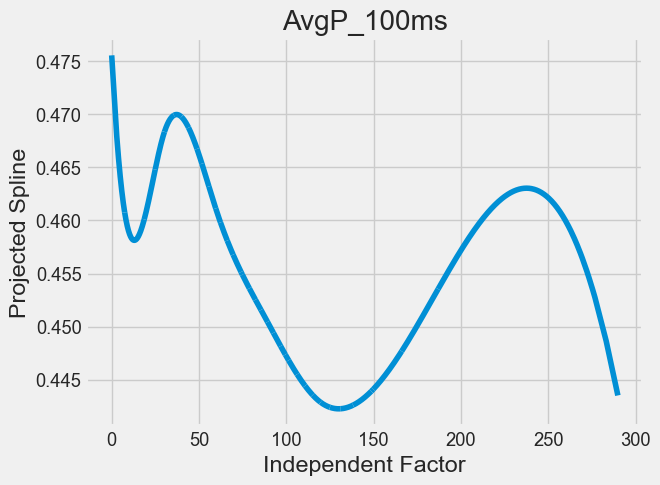

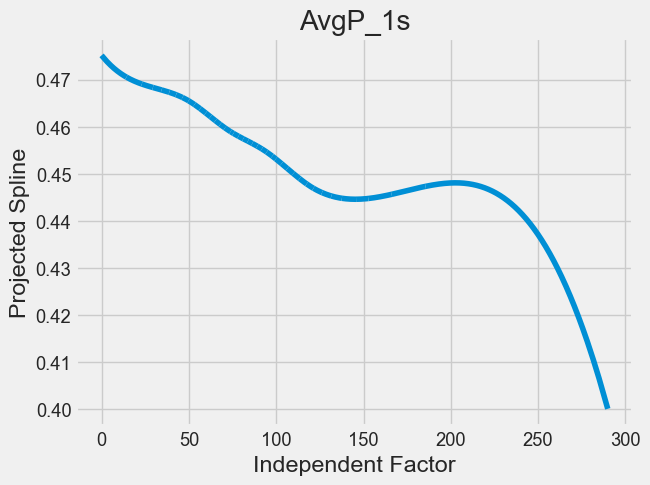

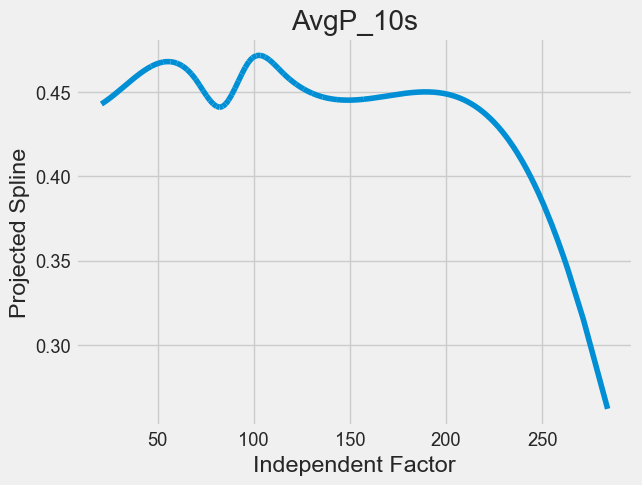

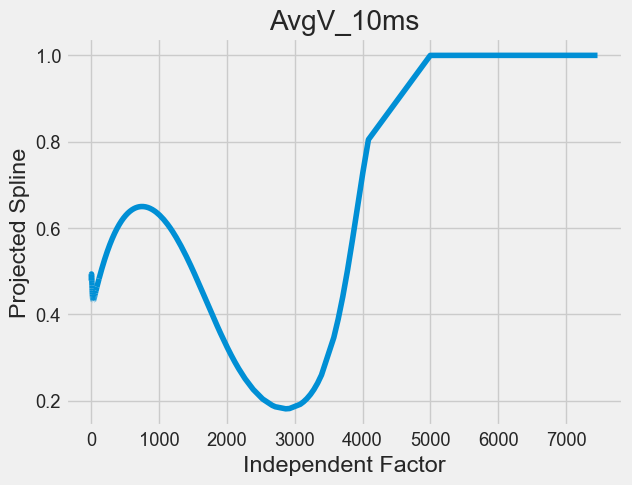

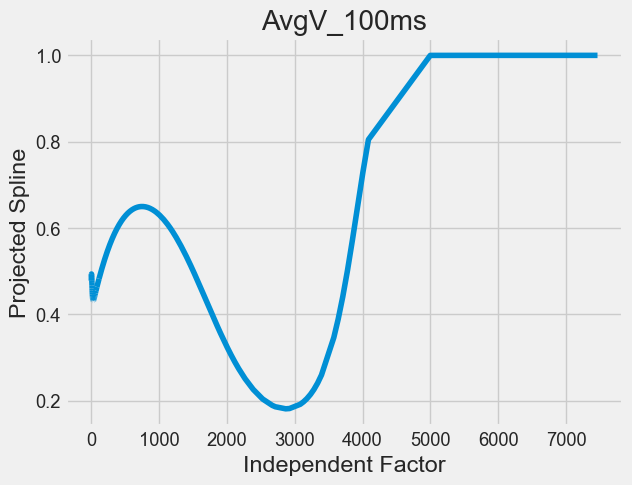

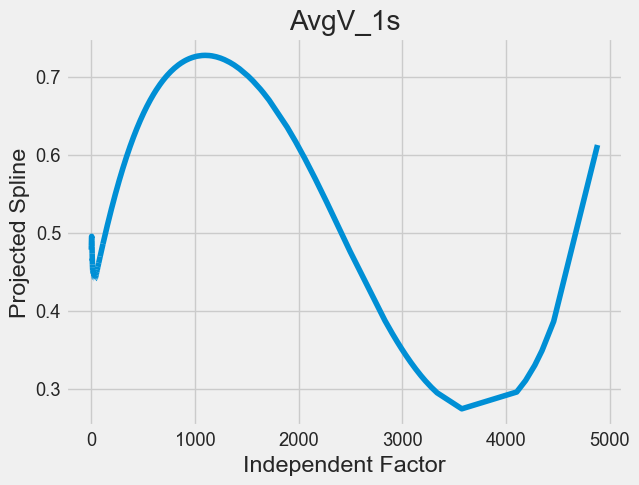

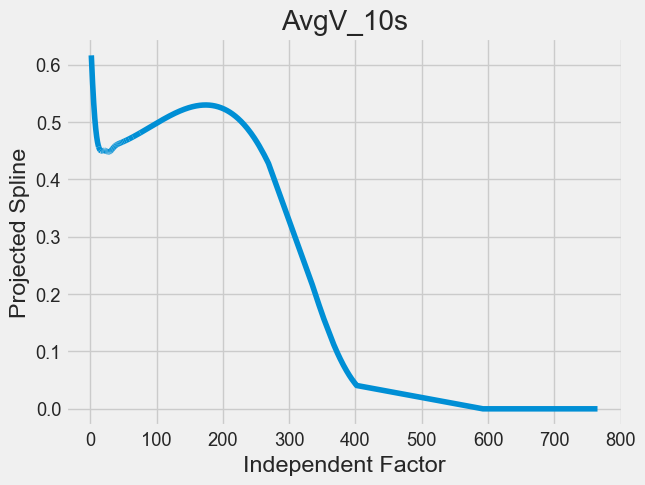

In [133]:
# Saving plotted splines
import matplotlib.pyplot as plt
for name in column_names:
    df_plotting_1 = pd.DataFrame()
    df_plotting_1['x'] = X[name]  # put the name of any feature here
    df_plotting_1['y'] = df_transformed[name].tolist()  # put the name of the same feature here
    df_plotting_1 = df_plotting_1.sort_values(by = 'x', ascending = True)

    plt.figure()
    plt.plot(df_plotting_1['x'],df_plotting_1['y'],)
    plt.xlabel('Independent Factor')
    plt.ylabel('Projected Spline')
    plt.title(name)  # put the name of the same feature here as a title
    plt.savefig(name+'.png')

In [134]:
df_transformaed = X

In [135]:
# Splitting transformed data 
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.2, random_state = 0, stratify=Y)

In [136]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 800, num = 8)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [10, 15]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 4, 6]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'min_samples_split': [10, 15], 'min_samples_leaf': [2, 4, 6], 'bootstrap': [True, False]}


In [137]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 15, cv = 4, verbose=2, random_state=42)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 4 folds for each of 15 candidates, totalling 60 fits
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=6, min_samples_split=15, n_estimators=500; total time=  40.4s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=6, min_samples_split=15, n_estimators=500; total time=  26.3s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=6, min_samples_split=15, n_estimators=500; total time=  25.0s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=6, min_samples_split=15, n_estimators=500; total time=  24.6s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=700; total time=  41.5s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=700; total time=  53.5s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=7

RandomizedSearchCV(cv=4, estimator=RandomForestClassifier(), n_iter=15,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [2, 4, 6],
                                        'min_samples_split': [10, 15],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800]},
                   random_state=42, verbose=2)

In [138]:
# Best Parameters
rf_random.best_params_

{'n_estimators': 700,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 70,
 'bootstrap': False}

In [139]:
# Random Forest with RandomSearch
final_model = rf_random.best_estimator_
y_pred_best = final_model.predict(X_test)

In [140]:
print(confusion_matrix(y_test,y_pred_best))
print("\n")
print(classification_report(y_test,y_pred_best))

[[37242  5742]
 [ 8745 27405]]


              precision    recall  f1-score   support

           0       0.81      0.87      0.84     42984
           1       0.83      0.76      0.79     36150

    accuracy                           0.82     79134
   macro avg       0.82      0.81      0.81     79134
weighted avg       0.82      0.82      0.82     79134



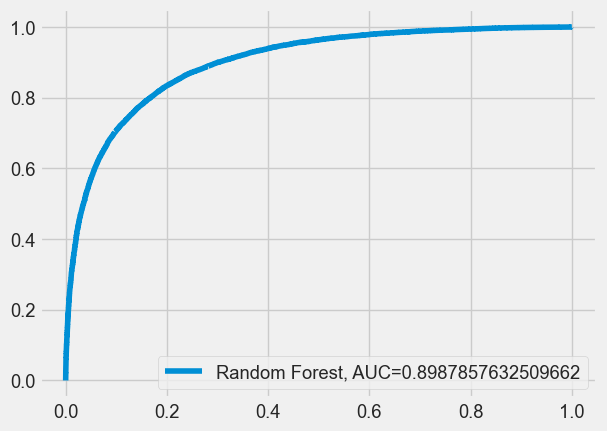

In [141]:
y_pred_proba_1 = final_model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba_1)
auc = metrics.roc_auc_score(y_test, y_pred_proba_1)
plt.plot(fpr,tpr,label="Random Forest, AUC="+str(auc))
plt.legend(loc=4)
# plt.savefig('ORC_and_AUC.pdf')
plt.show()